In [179]:
import os
import random
import shutil

data_dir = 'C:/Users/pacofarina/davidUAVClassification-2/Data/Spectrogram Datasets/Overlapping/size900_overlap10/combined'
train_dir = 'C:/Users/pacofarina/davidUAVClassification-2/Data/Spectrogram Datasets/Overlapping/size900_overlap10/combined/train'
val_dir = 'C:/Users/pacofarina/davidUAVClassification-2/Data/Spectrogram Datasets/Overlapping/size900_overlap10/combined/val'

# create train and val directories if they do not exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# set the validation split ratio
val_split_ratio = 0.3

# loop over each class folder in the dataset
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        # create train and val class directories if they do not exist
        if not os.path.exists(train_class_dir):
            os.makedirs(train_class_dir)
        if not os.path.exists(val_class_dir):
            os.makedirs(val_class_dir)
        # loop over each image in the class folder
        for img_name in os.listdir(class_dir):
            img_src = os.path.join(class_dir, img_name)
            if os.path.isfile(img_src):
                # randomly assign images to train or val set based on the validation split ratio
                if random.random() < val_split_ratio:
                    shutil.copy(img_src, os.path.join(val_class_dir, img_name))
                else:
                    shutil.copy(img_src, os.path.join(train_class_dir, img_name))


In [180]:
import os
import shutil
import random

train_dir = "C:/Users/pacofarina/davidUAVClassification-2/Data/Spectrogram Datasets/Overlapping/size900_overlap10/combined/val"
test_dir = "C:/Users/pacofarina/davidUAVClassification-2/Data/Spectrogram Datasets/Overlapping/size900_overlap10/combined/test"
test_size = 0.5  # 10% of the images will be moved to the test directory

# Create the test directory if it doesn't exist
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Loop over the subdirectories in the train directory
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        # Create a subdirectory in the test directory for the current class
        test_subdir_path = os.path.join(test_dir, subdir)
        if not os.path.exists(test_subdir_path):
            os.mkdir(test_subdir_path)

        # Get a list of all the image files in the current class directory
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)

        # Calculate the number of images to move to the test directory
        num_test_images = int(test_size * num_images)

        # Randomly select the images to move to the test directory
        test_images = random.sample(image_files, num_test_images)

        # Move the test images to the test directory
        for image in test_images:
            src_path = os.path.join(subdir_path, image)
            dest_path = os.path.join(test_subdir_path, image)
            shutil.move(src_path, dest_path)


In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader



In [182]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.4762, 0.8758, 0.4969], [0.3287, 0.2301, 0.3282])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.4762, 0.8758, 0.4969], [0.3287, 0.2301, 0.3282])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.4762, 0.8758, 0.4969], [0.3287, 0.2301, 0.3282])
    ]),
}

data_dir = 'C:/Users/pacofarina/davidUAVClassification-2/Data/Spectrogram Datasets/Overlapping/size900_overlap10/combined'
num_classes=5
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

# Calculate the number of examples in each class in the train dataset
class_counts = [0] * num_classes
for idx in range(len(image_datasets["train"])):
    _, label = image_datasets["train"][idx]
    class_counts[label] += 1

# Calculate weights for each class
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for _, label in image_datasets["train"]]

# Create a sampler for the train dataset using the weights
train_sampler = WeightedRandomSampler(sample_weights, len(image_datasets["train"]), replacement=True)

# Create a sampler for the validation dataset using the class distribution of the train dataset
val_class_counts = [0] * num_classes
for idx in range(len(image_datasets["val"])):
    _, label = image_datasets["val"][idx]
    val_class_counts[label] += 1
val_weights = [1.0 / count for count in val_class_counts]
val_sample_weights = [val_weights[label] for _, label in image_datasets["val"]]
val_sampler = WeightedRandomSampler(val_sample_weights, len(image_datasets["val"]), replacement=True)





# Create data loaders for the train and test sets
train_loader = DataLoader(image_datasets["train"], batch_size=32, sampler=train_sampler)
test_loader = DataLoader(image_datasets["test"], batch_size=32 )
val_loader = DataLoader(image_datasets["val"], batch_size=32,sampler=val_sampler)

# Combine the loaders into a dictionary
dataloaders = {'train': train_loader, 'test': test_loader, 'val': val_loader}

In [91]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(dataloaders["train"])
print("mean and std: \n", mean, std)



mean and std: 
 tensor([0.4762, 0.8758, 0.4969]) tensor([0.3287, 0.2301, 0.3282])


In [94]:
print("Train set length:",len(dataloaders["train"]))
print("Validation set length:",len(dataloaders["val"]))
print("Test set length:",len(dataloaders["test"]))

Train set length: 1771
Validation set length: 492
Test set length: 197


In [ ]:
# data_dir = 'C:/Users/pacofarina/davidUAVClassification-2/Data/Spectrogram Datasets/Overlapping/size300_overlap10/combined'

# dataset = datasets.ImageFolder(root=data_dir, transform=transforms.Compose([
#         transforms.Resize(256),
#         transforms.ToTensor()
#         #,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]))



# val_size = 0.2
# test_size = 0.2

# dataset_size = len(dataset)
# test_size = int(test_size * dataset_size)
# val_size = int(val_size * (dataset_size - test_size))
# train_size = dataset_size - val_size - test_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# #################

# labels = [train_dataset[idx][1] for idx in range(len(train_dataset))]

# stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)

# train_idx, val_idx = next(stratified_split.split(train_dataset, labels))



# # Create a random sampler for the training set
# train_sampler = SubsetRandomSampler(train_idx)

# # Create a DataLoader for the training set using the random sampler
# train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)

# # Create a random sampler for the validation set
# val_sampler = SubsetRandomSampler(val_idx)

# # Create a DataLoader for the validation set using the random sampler
# val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)

# # Create a DataLoader for the test set using no shuffling
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# dataloaders = {'train': train_loader, 'test': test_loader, 'val': val_loader}

# print("Train set length:",len(dataloaders["train"]))
# print("Validation set length:",len(dataloaders["val"]))
# print("Test set length:",len(dataloaders["test"]))


In [7]:
torch.save(train_dataset, "train_dataset_strat.pt")
torch.save(val_dataset, "val_dataset_strat.pt")
torch.save(test_dataset, "test_dataset_strat.pt")

NameError: name 'train_dataset' is not defined

In [ ]:
# #Initialize model

# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 5)  # 5 classes in the dataset

# # Freeze all the layers
# for param in model_ft.parameters():
#     param.requires_grad = False

# # Unfreeze the last few layers
# num_unfrozen_layers = 3
# for param in model_ft.layer4[-num_unfrozen_layers:].parameters():
#     param.requires_grad = True

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_ft.to(device)

# #selecting criterion
# criterion=nn.CrossEntropyLoss()
# #Initialize optimizer
# optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
# #optimizer.to(device)


In [ ]:
# def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=10):
#     train_loss = []
#     val_loss = []
#     train_acc = []
#     val_acc = []

#     train_loader = dataloaders['train']
#     val_loader = dataloaders['val']
#     test_loader= dataloaders['test']

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch+1}/{num_epochs}')
#         print('-' * 10)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  
#                 loader = train_loader
#             else:
#                 model.eval()   
#                 loader = val_loader

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(loader.dataset)
#             epoch_acc = running_corrects.double() / len(loader.dataset)

#             if phase == 'train':
#                 train_loss.append(epoch_loss)
#                 train_acc.append(epoch_acc)
#             else:
#                 val_loss.append(epoch_loss)
#                 val_acc.append(epoch_acc)

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#         print()

#     print('Training complete')

    
#     return model, train_loss, val_loss, train_acc, val_acc


In [ ]:
# trained_model, train_loss, val_loss, train_acc, val_acc= train_model(model_ft, criterion, optimizer, dataloaders, device, num_epochs=10)

In [ ]:
# torch.save(trained_model.state_dict(), 'C:/Users/pacofarina/davidUAVClassification-2/2. classification/CNNs/trained_model_state_dict.pth')

# torch.save(trained_model, 'C:/Users/pacofarina/davidUAVClassification-2/2. classification/CNNs/trained_model.pth')

In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, precision_score, recall_score, f1_score

# # Load the trained model
# torch.save(trained_model.state_dict(), 'C:/Users/pacofarina/davidUAVClassification-2/2. classification/CNNs/trained_model_state_dict.pth')

# torch.save(trained_model, 'C:/Users/pacofarina/davidUAVClassification-2/2. classification/CNNs/trained_model.pth')
# model = torch.load("trained_model.pth")



# # Set the model to evaluation mode
# model.eval()

# # Get the test dataloader
# test_dataloader = dataloaders["test"]

# # Initialize the list of ground truth and predicted labels
# true_labels = []
# pred_labels = []

# # Iterate over the test dataloader and feed the images through the model
# with torch.no_grad():
#     for images, labels in test_dataloader:
#         # Move the images and labels to the device
#         images = images.to(device)
#         labels = labels.to(device)

#         # Feed the images through the model
#         outputs = model(images)

#         # Get the predicted labels
#         _, predicted = torch.max(outputs, 1)

#         # Append the true and predicted labels to the lists
#         true_labels.extend(labels.cpu().numpy())
#         pred_labels.extend(predicted.cpu().numpy())

# # Calculate the test accuracy
# test_accuracy = accuracy_score(true_labels, pred_labels)
# print("Test Accuracy:", test_accuracy)

# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(true_labels, pred_labels)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Calculate the classification report
# class_report = classification_report(true_labels, pred_labels)
# print("Classification Report:")
# print(class_report)

# # Calculate the precision, recall, and F1 score for each class
# precision = precision_score(true_labels, pred_labels, average=None)
# recall = recall_score(true_labels, pred_labels, average=None)
# f1 = f1_score(true_labels, pred_labels, average=None)
# print("Class Precision:", precision)
# print("Class Recall:", recall)
# print("Class F1 Score:", f1)


In [103]:
import torch.nn as nn
import torchvision.models as models

class MyResNet18(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(MyResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         num_unfrozen_layers = 3
#         for param in self.resnet.layer4[-num_unfrozen_layers:].parameters():
#             param.requires_grad = True

        num_ftrs = self.resnet.fc.in_features
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, criterion, optimizer, dataloaders, device, num_epochs=3):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        self.num_epochs=num_epochs

        self.train_loader = dataloaders['train']
        self.val_loader = dataloaders['val']
        self.test_loader= dataloaders['test']

        self.optimizer=optimizer

        self.criterion=criterion

        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.train()  
                    loader = self.train_loader
                else:
                    self.eval()   
                    loader = self.val_loader

                self.running_loss = 0.0
                self.running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.forward(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    self.running_loss += loss.item() * inputs.size(0)
                    self.running_corrects += torch.sum(preds == labels.data)

                epoch_loss = self.running_loss / len(loader.dataset)
                epoch_acc = self.running_corrects.double() / len(loader.dataset)

                if phase == 'train':
                    self.train_loss.append(epoch_loss)
                    self.train_acc.append(epoch_acc)
                else:
                    self.val_loss.append(epoch_loss)
                    self.val_acc.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            print()

        print('Training complete')

    
        return model, train_loss, val_loss, train_acc, val_acc



In [119]:
class myCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super( myCNN, self).__init__()
        
        self.conv1= conv_layer = nn.Conv2d(
                                                in_channels=3, # input channels, e.g. 3 for RGB images
                                                out_channels=16, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv2= conv_layer = nn.Conv2d(
                                                in_channels=16, # input channels, e.g. 3 for RGB images
                                                out_channels=16, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv3= conv_layer = nn.Conv2d(
                                                in_channels=16, # input channels, e.g. 3 for RGB images
                                                out_channels=32, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv4= conv_layer = nn.Conv2d(
                                                in_channels=32, # input channels, e.g. 3 for RGB images
                                                out_channels=32, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv5= conv_layer = nn.Conv2d(
                                                in_channels=32, # input channels, e.g. 3 for RGB images
                                                out_channels=64, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv6= conv_layer = nn.Conv2d(
                                                in_channels=64, # input channels, e.g. 3 for RGB images
                                                out_channels=64, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.relu = nn.ReLU()
        
        
        self.maxpool= nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)
        
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x) 
        
        
        
        return x
    
    def train_model(self, criterion, optimizer, dataloaders, device, num_epochs=3,patience=3):
        
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        self.num_epochs=num_epochs

        self.train_loader = dataloaders['train']
        self.val_loader = dataloaders['val']
        self.test_loader= dataloaders['test']

        self.optimizer=optimizer

        self.criterion=criterion
        
         # Initialize variables for early stopping
        best_val_loss = float('inf')  # <1>
        epochs_no_improve = 0  # <2>

        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.train()  
                    loader = self.train_loader
                else:
                    self.eval()   
                    loader = self.val_loader

                self.running_loss = 0.0
                self.running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.forward(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    self.running_loss += loss.item() * inputs.size(0)
                    self.running_corrects += torch.sum(preds == labels.data)

                epoch_loss = self.running_loss / len(loader.dataset)
                epoch_acc = self.running_corrects.double() / len(loader.dataset)

                if phase == 'train':
                    self.train_loss.append(epoch_loss)
                    self.train_acc.append(epoch_acc)
                else:
                    self.val_loss.append(epoch_loss)
                    self.val_acc.append(epoch_acc)
                    
                    
                 # Early stopping check
                if epoch_loss < best_val_loss:  # <3>
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:  # <4>
                        print(f'Early stopping after {epoch+1} epochs.')
                        return self, self.train_loss, self.val_loss, self.train_acc, self.val_acc

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            print()

        print('Training complete')

        return self, self.train_loss, self.val_loss, self.train_acc, self.val_acc

class myCNN_reduced(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super( myCNN_reduced, self).__init__()
        
        self.conv1= conv_layer = nn.Conv2d(
                                                in_channels=3, # input channels, e.g. 3 for RGB images
                                                out_channels=16, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv2= conv_layer = nn.Conv2d(
                                                in_channels=16, # input channels, e.g. 3 for RGB images
                                                out_channels=16, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv3= conv_layer = nn.Conv2d(
                                                in_channels=16, # input channels, e.g. 3 for RGB images
                                                out_channels=32, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv4= conv_layer = nn.Conv2d(
                                                in_channels=32, # input channels, e.g. 3 for RGB images
                                                out_channels=32, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv5= conv_layer = nn.Conv2d(
                                                in_channels=32, # input channels, e.g. 3 for RGB images
                                                out_channels=64, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv6= conv_layer = nn.Conv2d(
                                                in_channels=64, # input channels, e.g. 3 for RGB images
                                                out_channels=64, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.relu = nn.ReLU()
        
        
        self.maxpool= nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, num_classes)
        
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)

        x = self.conv3(x)
        #x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)
        
        x = self.conv5(x)
        #x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)
        
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x) 
        
        
        
        return x
    
    def train_model(self, criterion, optimizer, dataloaders, device, num_epochs=3,patience=5):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        self.num_epochs=num_epochs

        self.train_loader = dataloaders['train']
        self.val_loader = dataloaders['val']
        self.test_loader= dataloaders['test']

        self.optimizer=optimizer

        self.criterion=criterion
        
         # Initialize variables for early stopping
        best_val_loss = float('inf')  # <1>
        epochs_no_improve = 0  # <2>

        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.train()  
                    loader = self.train_loader
                else:
                    self.eval()   
                    loader = self.val_loader

                self.running_loss = 0.0
                self.running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.forward(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    self.running_loss += loss.item() * inputs.size(0)
                    self.running_corrects += torch.sum(preds == labels.data)

                epoch_loss = self.running_loss / len(loader.dataset)
                epoch_acc = self.running_corrects.double() / len(loader.dataset)

                if phase == 'train':
                    self.train_loss.append(epoch_loss)
                    self.train_acc.append(epoch_acc)
                else:
                    self.val_loss.append(epoch_loss)
                    self.val_acc.append(epoch_acc)
                    
                    
                 # Early stopping check
                if epoch_loss < best_val_loss:  # <3>
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:  # <4>
                        print(f'Early stopping after {epoch+1} epochs.')
                        return self, self.train_loss, self.val_loss, self.train_acc, self.val_acc

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            print()

        print('Training complete')

        return self, self.train_loss, self.val_loss, self.train_acc, self.val_acc

class myCNN_extended(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super( myCNN, self).__init__()
        
        self.conv1= conv_layer = nn.Conv2d(
                                                in_channels=3, # input channels, e.g. 3 for RGB images
                                                out_channels=16, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv2= conv_layer = nn.Conv2d(
                                                in_channels=16, # input channels, e.g. 3 for RGB images
                                                out_channels=16, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv3= conv_layer = nn.Conv2d(
                                                in_channels=16, # input channels, e.g. 3 for RGB images
                                                out_channels=32, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv4= conv_layer = nn.Conv2d(
                                                in_channels=32, # input channels, e.g. 3 for RGB images
                                                out_channels=32, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv5= conv_layer = nn.Conv2d(
                                                in_channels=32, # input channels, e.g. 3 for RGB images
                                                out_channels=64, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv6= conv_layer = nn.Conv2d(
                                                in_channels=64, # input channels, e.g. 3 for RGB images
                                                out_channels=64, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        
        self.conv7= conv_layer = nn.Conv2d(
                                                in_channels=64, # input channels, e.g. 3 for RGB images
                                                out_channels=128, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.conv8= conv_layer = nn.Conv2d(
                                                in_channels=128, # input channels, e.g. 3 for RGB images
                                                out_channels=128, # output channels, e.g. 64 for ResNet18
                                                kernel_size=3, # kernel size, e.g. 7 for ResNet18
                                                stride=2, # stride, e.g. 2 for ResNet18
                                                padding=3, # padding, e.g. 3 for ResNet18
                                                bias=False # whether to include bias or not, e.g. False for ResNet18
                                            )
        self.relu = nn.ReLU()
        
        
        self.maxpool= nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)
        
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x = self.dropout(x)
        
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x) 
        
        
        
        return x
    
    def train_model(self, criterion, optimizer, dataloaders, device, num_epochs=3,patience=3):
        
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        self.num_epochs=num_epochs

        self.train_loader = dataloaders['train']
        self.val_loader = dataloaders['val']
        self.test_loader= dataloaders['test']

        self.optimizer=optimizer

        self.criterion=criterion
        
         # Initialize variables for early stopping
        best_val_loss = float('inf')  # <1>
        epochs_no_improve = 0  # <2>

        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.train()  
                    loader = self.train_loader
                else:
                    self.eval()   
                    loader = self.val_loader

                self.running_loss = 0.0
                self.running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.forward(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    self.running_loss += loss.item() * inputs.size(0)
                    self.running_corrects += torch.sum(preds == labels.data)

                epoch_loss = self.running_loss / len(loader.dataset)
                epoch_acc = self.running_corrects.double() / len(loader.dataset)

                if phase == 'train':
                    self.train_loss.append(epoch_loss)
                    self.train_acc.append(epoch_acc)
                else:
                    self.val_loss.append(epoch_loss)
                    self.val_acc.append(epoch_acc)
                    
                    
                 # Early stopping check
                if epoch_loss < best_val_loss:  # <3>
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:  # <4>
                        print(f'Early stopping after {epoch+1} epochs.')
                        return self, self.train_loss, self.val_loss, self.train_acc, self.val_acc

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            print()

        print('Training complete')

        return self, self.train_loss, self.val_loss, self.train_acc, self.val_acc


In [260]:
model_ft = myCNN(num_classes=5, dropout_rate=0.5)#0.5


#select cuda as device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#put model in cuda
model_ft.to(device)
#selecting criterion
criterion=nn.CrossEntropyLoss()
#Initialize optimizer
optimizer = optim.Adam(model_ft.parameters (), lr=0.0001)
#optimizer.to(device)
trained_model, train_loss, val_loss, train_acc, val_acc=model_ft.train_model(criterion, optimizer, dataloaders, device, num_epochs=100,patience=3)

Epoch 1/100
----------
train Loss: 1.5160 Acc: 0.3365
val Loss: 1.4228 Acc: 0.4370

Epoch 2/100
----------
train Loss: 1.3994 Acc: 0.4786
val Loss: 1.3948 Acc: 0.4687

Epoch 3/100
----------
train Loss: 1.3491 Acc: 0.5425
val Loss: 1.3259 Acc: 0.5685

Epoch 4/100
----------
train Loss: 1.2979 Acc: 0.6020
val Loss: 1.2812 Acc: 0.6070

Epoch 5/100
----------
train Loss: 1.2582 Acc: 0.6448
val Loss: 1.2553 Acc: 0.6449

Epoch 6/100
----------
train Loss: 1.2275 Acc: 0.6756
val Loss: 1.2588 Acc: 0.6360

Epoch 7/100
----------
train Loss: 1.2079 Acc: 0.6954
val Loss: 1.2671 Acc: 0.6305

Epoch 8/100
----------
train Loss: 1.1925 Acc: 0.7106
val Loss: 1.2572 Acc: 0.6434

Epoch 9/100
----------
train Loss: 1.1784 Acc: 0.7255
val Loss: 1.2656 Acc: 0.6392

Epoch 10/100
----------
train Loss: 1.1671 Acc: 0.7365
val Loss: 1.2204 Acc: 0.6791

Epoch 11/100
----------
train Loss: 1.1530 Acc: 0.7513
val Loss: 1.2531 Acc: 0.6497

Epoch 12/100
----------
train Loss: 1.1393 Acc: 0.7654
val Loss: 1.2755 Ac

In [176]:
saved_dict = torch.load("C:/Users/pacofarina/davidUAVClassification-2/2. classification/CNNs/test_logs/size900_overlap10/test5/trained_model.pth")

'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'


model = myCNN(num_classes=5, dropout_rate=0.5)
model.conv1.weight = nn.Parameter(saved_dict['conv1.weight'])
model.conv2.weight = nn.Parameter(saved_dict['conv2.weight'])
model.conv3.weight = nn.Parameter(saved_dict['conv3.weight'])
model.conv4.weight = nn.Parameter(saved_dict['conv4.weight'])
model.conv5.weight = nn.Parameter(saved_dict['conv5.weight'])
model.conv6.weight = nn.Parameter(saved_dict['conv6.weight'])

model.fc1.weight = nn.Parameter(saved_dict['fc1.weight'])
model.fc2.weight = nn.Parameter(saved_dict['fc2.weight'])
model.fc3.weight = nn.Parameter(saved_dict['fc3.weight'])
model.fc4.weight = nn.Parameter(saved_dict['fc4.weight'])

model.fc1.bias = nn.Parameter(saved_dict['fc1.bias'])
model.fc2.bias = nn.Parameter(saved_dict['fc2.bias'])
model.fc3.bias = nn.Parameter(saved_dict['fc3.bias'])
model.fc4.bias = nn.Parameter(saved_dict['fc4.bias'])



In [261]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, precision_score, recall_score, f1_score

# Load the trained model
#torch.save(trained_model.state_dict(), 'C:/Users/pacofarina/davidUAVClassification-2/2. classification/CNNs/trained_model_state_dict.pth')

# Load the saved dictionary

# Extract the model from the saved dictionary
#model = saved_dict['model']

# Set the model to evaluation mode
model.eval()

# Get the test dataloader
test_dataloader = dataloaders["test"]

# Initialize the list of ground truth and predicted labels
true_labels = []
pred_labels = []

# Iterate over the test dataloader and feed the images through the model
with torch.no_grad():
    for images, labels in test_dataloader:
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Feed the images through the model
        outputs = model(images)

        # Get the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append the true and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Calculate the test accuracy
test_accuracy = accuracy_score(true_labels, pred_labels)
print("Test Accuracy:", test_accuracy)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report
class_report = classification_report(true_labels, pred_labels)
print("Classification Report:")
print(class_report)

# Calculate the precision, recall, and F1 score for each class
precision = precision_score(true_labels, pred_labels, average=None)
recall = recall_score(true_labels, pred_labels, average=None)
f1 = f1_score(true_labels, pred_labels, average=None)
print("Class Precision:", precision)
print("Class Recall:", recall)
print("Class F1 Score:", f1)






AttributeError: 'myCNN' object has no attribute 'fc3'

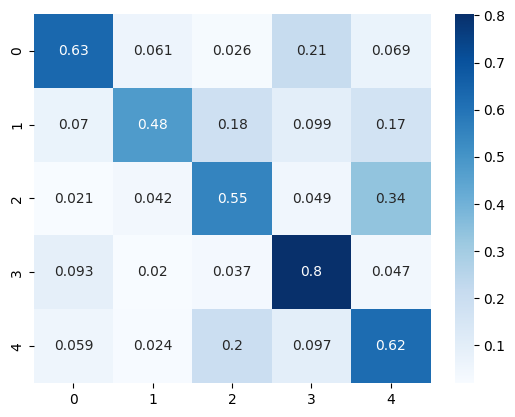

In [163]:
import seaborn as sns

fig,ax = plt.subplots()
cm_percentages = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

cm_plot=sns.heatmap(cm_percentages, annot=True, cmap='Blues')

#fig.savefig("test_logs/size900_overlap10/test5/cm_plot.svg")

In [99]:
# Save the results to a file
with open("test_logs/size900_overlap10/test5/test5_results.txt", "w") as f:
    f.write("Test Accuracy: {}\n".format(test_accuracy))
    f.write("Confusion Matrix:\n{}\n".format(conf_matrix))
    f.write("Classification Report:\n{}\n".format(class_report))
    f.write("Class Precision:\n{}\n".format(precision))
    f.write("Class Recall:\n{}\n".format(recall))
    f.write("Class F1 Score:\n{}\n".format(f1))

# Save the trained model
torch.save(model.state_dict(), "test_logs/size900_overlap10/test5/trained_model.pth")
print("Model saved to trained_model.pth")



Model saved to trained_model.pth


In [231]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import logging
import os

# Set up the logging
logging.basicConfig(filename='test_logs/size900_overlap10/test1.log', filemode='w', format='%(asctime)s - %(message)s', level=logging.INFO)

# Load the trained model
model = torch.load("trained_simple_CNN.pth")


# Set the model to evaluation mode
model.eval()

# Get the test dataloader
test_dataloader = dataloaders["test"]

# Initialize the list of ground truth and predicted labels
true_labels = []
pred_labels = []

# Iterate over the test dataloader and feed the images through the model
with torch.no_grad():
    for images, labels in test_dataloader:
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Feed the images through the model
        outputs = model(images)

        # Get the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append the true and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Calculate the test accuracy
test_accuracy = accuracy_score(true_labels, pred_labels)
logging.info('Test Accuracy: {}'.format(test_accuracy))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
logging.info('Confusion Matrix')
                    
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report
class_report = classification_report(true_labels, pred_labels)
print("Classification Report:")
print(class_report)

# Calculate the precision, recall, and F1 score for each class
precision = precision_score(true_labels, pred_labels, average=None)
recall = recall_score(true_labels, pred_labels, average=None)
f1 = f1_score(true_labels, pred_labels, average=None)
print("Class Precision:", precision)
print("Class Recall:", recall)
print("Class F1 Score:", f1)

# Save the results to a file
with open("test_results.txt", "w") as f:
    f.write("Test Accuracy: {}\n".format(test_accuracy))
    f.write("Confusion Matrix:\n{}\n".format(conf_matrix))
    f.write("Classification Report:\n{}\n".format(class_report))
    f.write("Class Precision:\n{}\n".format(precision))
    f.write("Class Recall:\n{}\n".format(recall))
    f.write("Class F1 Score:\n{}\n".format(f1))

# Save the trained model
torch.save(model.state_dict(), "trained_model.pth")
print("Model saved to trained_model.pth")





AttributeError: 'myCNN' object has no attribute 'fc3'

Confusion Matrix:
 [[ 115    5    3   25    5]
 [   1   10    1    0    3]
 [   1    1   18    4   11]
 [ 660  122  118 4910  186]
 [   4    3   11    8   69]]

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.75      0.25       153
           1       0.07      0.67      0.13        15
           2       0.12      0.51      0.19        35
           3       0.99      0.82      0.90      5996
           4       0.25      0.73      0.37        95

    accuracy                           0.81      6294
   macro avg       0.32      0.70      0.37      6294
weighted avg       0.95      0.81      0.87      6294

Class Precision:
0.15 0.07 0.12 0.99 0.25 
Class Recall:
0.75 0.67 0.51 0.82 0.73 
Class F1 Score:
0.25 0.13 0.19 0.9 0.37 

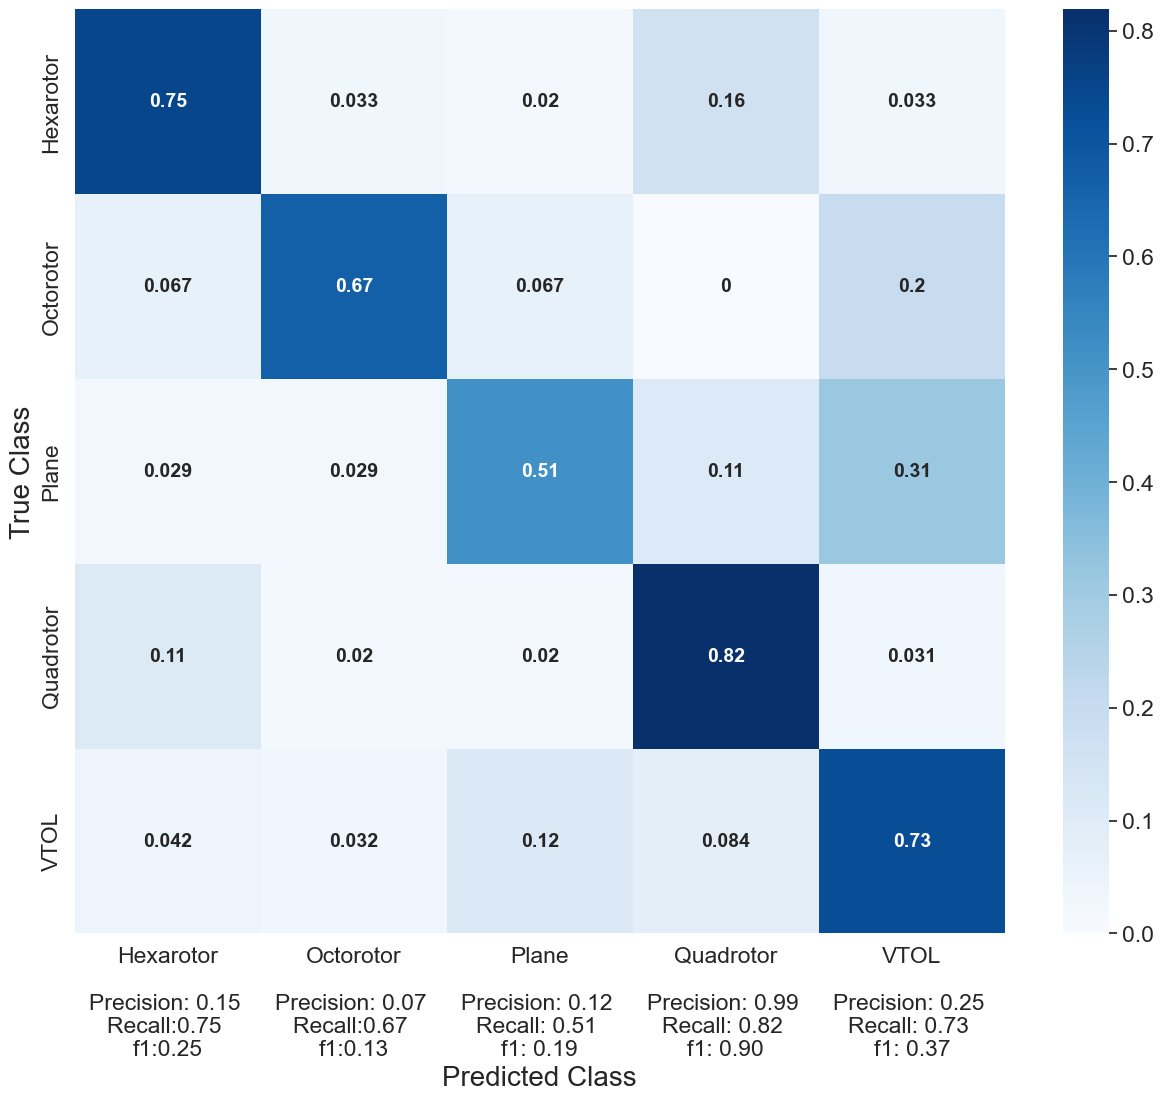

In [259]:
import numpy as np

# Initialize the confusion matrix
confusion_matrix_data = np.array([[115, 5, 3, 25, 5],
                                  [1, 10, 1, 0, 3],
                                  [1, 1, 18, 4, 11],
                                  [660, 122, 118, 4910, 186],
                                  [4, 3, 11, 8, 69]])

# Initialize the classification report
classification_report_str = '''              precision    recall  f1-score   support

           0       0.15      0.75      0.25       153
           1       0.07      0.67      0.13        15
           2       0.12      0.51      0.19        35
           3       0.99      0.82      0.90      5996
           4       0.25      0.73      0.37        95

    accuracy                           0.81      6294
   macro avg       0.32      0.70      0.37      6294
weighted avg       0.95      0.81      0.87      6294'''

classification_report_data = {}
classification_report_data['0'] = {'precision': 0.15, 'recall': 0.75, 'f1-score': 0.25, 'support': 153}
classification_report_data['1'] = {'precision': 0.07, 'recall': 0.67, 'f1-score': 0.13, 'support': 15}
classification_report_data['2'] = {'precision': 0.12, 'recall': 0.51, 'f1-score': 0.19, 'support': 35}
classification_report_data['3'] = {'precision': 0.99, 'recall': 0.82, 'f1-score': 0.90, 'support': 5996}
classification_report_data['4'] = {'precision': 0.25, 'recall': 0.73, 'f1-score': 0.37, 'support': 95}

# Print the confusion matrix and classification report to verify the data
print("Confusion Matrix:\n", confusion_matrix_data)
print("\nClassification Report:\n", classification_report_str)
print("\nClass Precision:")
for key in classification_report_data:
    print(classification_report_data[key]['precision'], end=' ')
print("\nClass Recall:")
for key in classification_report_data:
    print(classification_report_data[key]['recall'], end=' ')
print("\nClass F1 Score:")
for key in classification_report_data:
    print(classification_report_data[key]['f1-score'], end=' ')

    
fig,ax = plt.subplots(figsize=(15,12))
cm_percentages = confusion_matrix_data.astype('float') / confusion_matrix_data.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
cm_plot=sns.heatmap(cm_percentages, annot=True, cmap='Blues', 
                    xticklabels=["Hexarotor\n\nPrecision: 0.15 \nRecall:0.75 \nf1:0.25",
                                 "Octorotor\n\nPrecision: 0.07 \nRecall:0.67 \nf1:0.13",
                                 "Plane\n\nPrecision: 0.12 \nRecall: 0.51 \nf1: 0.19",
                                 "Quadrotor\n\nPrecision: 0.99 \nRecall: 0.82 \nf1: 0.90",
                                 "VTOL\n\nPrecision: 0.25 \nRecall: 0.73 \nf1: 0.37"],
                    yticklabels=["Hexarotor","Octorotor","Plane","Quadrotor","VTOL"],
                    annot_kws={'fontsize': 14, 'fontweight': 'bold'},)
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('True Class', fontsize=20)


fig.savefig("test_logs/size900_overlap10/test5/cm_plot_complete.svg")